In [1]:
import h5py
import numpy as np
import time
from collections import deque
from tqdm import tqdm

# TRAIN FILE

In [3]:
datafile = '../../data/interim/train.hdf5'
labels = np.array([])

with h5py.File(datafile, 'r') as f:
    keys = list(f.keys())
    for key in keys:
        labels = np.append(labels, f[key]['annotations']['fullness'][...])
        

In [10]:
mask = labels >= 0.50
print(f'Number of samples above or equal to 50: {np.sum(mask)}')
mask = labels < 0.50
print(f'Number of samples below 50: {np.sum(mask)}')

Number of samples above or equal to 50: 7832
Number of samples below 50: 2359


# ADD SMOTHING AND CLIPPING

In [2]:
def create_weight_list(length, decay_factor=1.5):
    """
    Create a weight list of specified length where:
    - The first entry has the highest weight.
    - Remaining weights decrease based on the decay factor.
    - The total sum equals 1.

    Args:
        length (int): Length of the weight list.
        decay_factor (float): Controls the rate of decrease. Higher values make weights drop faster.

    Returns:
        list: A list of weights summing to 1.
    """
    if length == 0:
        return []
    
    # Generate decreasing weights
    weights = [1 / (decay_factor ** i) for i in range(length)]
    
    # Normalize to ensure the sum is exactly 1
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    return normalized_weights

def _smooth(level, history, time_stamp = None, smooth_seconds=1):
    # Get the current timestamp
    if time_stamp is not None:
        try: 
            current_time = float(time_stamp)
        except:
            current_time = time.time()
    else:
        current_time = time.time()

    # Add the new prediction with its timestamp
    history.append((current_time, level))

    # Remove entries older than 1 second
    while history and history[0][0] < current_time - smooth_seconds:
        history.popleft()

    # Compute the weighted average of the remaining predictions
    if history:
        predictions = [pred for _, pred in history]
        weights = create_weight_list(len(predictions))
        filtered_p_w = [(pi, wi) for pi, wi in zip(predictions, weights) if pi is not None]
        predictions, weights = zip(*filtered_p_w)
        avg_prediction = np.convolve(predictions, weights[::-1], mode='valid')
    else:
        avg_prediction = 0  # Default if no predictions are in the window
    
    return history, avg_prediction

In [9]:
yolo_smoothing_queue = deque()
convnext_smoothing_queue = deque()

typoo = 'vertical'
smooth_seconds = 2.5
clip_val = 2.5
# load data from file
file_path = f'../../data/predictions/recording_{typoo}_all_frames_processed.hdf5'

yolo_smooth_dict = {}
convnext_smooth_dict = {}
yolo_clipped_dict = {}
convnext_clipped_dict = {}

with h5py.File(file_path, 'r') as hf:
    timestamps = list(hf.keys())

    if "frame" == timestamps[0].split("_")[0]:
        timestamps = sorted(timestamps, key=lambda x: int(x.split('_')[1]))
    else:
        timestamps = sorted(timestamps, key=lambda x: float(x))

    prev_timestamp = None

    for timestamp in tqdm(timestamps):
        yolo_prediction = hf[timestamp]['yolo']['percent'][...]
        convnext_prediction = hf[timestamp]['convnext']['percent'][...]
        yolo_smoothing_queue, smoothed_yolo = _smooth(yolo_prediction, yolo_smoothing_queue, timestamp, smooth_seconds)
        convnext_smoothing_queue, smoothed_convnext = _smooth(convnext_prediction, convnext_smoothing_queue, timestamp, smooth_seconds)

        yolo_smooth_dict[timestamp] = smoothed_yolo
        convnext_smooth_dict[timestamp] = smoothed_convnext

        # run a clipping of yolo and convnext that states no more than 10% difference between each frame
        if prev_timestamp is not None:
            yolo_clipped = np.clip(yolo_prediction, a_min=yolo_clipped_dict[prev_timestamp] - clip_val, a_max=yolo_clipped_dict[prev_timestamp] + clip_val)
            convnext_clipped = np.clip(convnext_prediction, a_min=convnext_clipped_dict[prev_timestamp] - clip_val, a_max=convnext_clipped_dict[prev_timestamp] + clip_val)
        else:
            yolo_clipped = yolo_prediction
            convnext_clipped = convnext_prediction
        
        yolo_clipped_dict[timestamp] = yolo_clipped
        convnext_clipped_dict[timestamp] = convnext_clipped
        
        prev_timestamp = timestamp

        

100%|██████████| 15715/15715 [00:19<00:00, 804.90it/s]


In [10]:
# Now we open the smaller files and write the smoothed predictions
data_path = f'../../data/predictions/new_run/recording_{typoo}_all_frames_processed_combined.hdf5'
with h5py.File(data_path, 'r+') as hf:
    timestamps = list(hf.keys())
    if "frame" == timestamps[0].split("_")[0]:
        timestamps = sorted(timestamps, key=lambda x: int(x.split('_')[1]))
    else:
        timestamps = sorted(timestamps, key=lambda x: float(x))
        
    for timestamp in tqdm(timestamps):
        # define the group for the timestamp
        group = hf[timestamp]
        if f'yolo_smooth_{smooth_seconds}' in group:
            del group[f'yolo_smooth_{smooth_seconds}']
        # create the group for the smoothed predictions
        yolo_smooth_group = group.create_group(f'yolo_smooth_{smooth_seconds}')
        # write the smoothed predictions
        yolo_smooth_group.create_dataset('percent', data=yolo_smooth_dict[timestamp])
        
        if f'convnext_smooth_{smooth_seconds}' in group:
            del group[f'convnext_smooth_{smooth_seconds}']
        # create the group for the smoothed predictions
        convnext_smooth_group = group.create_group(f'convnext_smooth_{smooth_seconds}')
        # write the smoothed predictions
        convnext_smooth_group.create_dataset('percent', data=convnext_smooth_dict[timestamp])

        if f'yolo_clipped_{clip_val}' in group:
            del group[f'yolo_clipped_{clip_val}']
        # create the group for the clipped predictions
        yolo_clipped_group = group.create_group(f'yolo_clipped_{clip_val}')
        # write the clipped predictions
        yolo_clipped_group.create_dataset('percent', data=yolo_clipped_dict[timestamp])

        if f'convnext_clipped_{clip_val}' in group:
            del group[f'convnext_clipped_{clip_val}']
        # create the group for the clipped predictions
        convnext_clipped_group = group.create_group(f'convnext_clipped_{clip_val}')
        # write the clipped predictions
        convnext_clipped_group.create_dataset('percent', data=convnext_clipped_dict[timestamp])

  0%|          | 0/417 [00:00<?, ?it/s]

100%|██████████| 417/417 [00:00<00:00, 602.40it/s]


# INVESTIGATE SPIKES

In [ ]:
import cv2
import matplotlib.pyplot as plt
data_path = '../../data/predictions/new_run/recording_vertical_all_frames_processed_combined.hdf5'

convnext_spikes = [
    '1736507484.6673949',
    '1736507489.7468805',
    '1736507545.5622058',
    '1736507550.6517587',
    '1736507555.7726688',
    '1736508660.8925276',
    '1736509421.5037076',
]

yolo_spikes = [
    '1736507479.5302064',
    '1736507484.6673949',
    '1736507489.7468805',
    '1736507494.8078063',
    '1736507535.5214877',
    '1736507540.5440507',
    '1736507545.5622058',
    '1736507550.6517587',
    '1736507931.1089373'
]

def decode_image(image):
    return cv2.imdecode(np.frombuffer(image, np.uint8), -1)

with h5py.File(data_path, 'r') as f:
    keys = convnext_spikes
    for i in range(len(convnext_spikes)):
        if 'scada' in f[keys[i]].keys():
            scada_group = f[keys[i]]['scada']
            scada_percent = scada_group['percent'][...].item()
            scada_line = scada_group['pixel'][...]
        else:
            scada_percent = None
            scada_line = None
            
        if 'yolo' in f[keys[i]].keys():
            yolo_group = f[keys[i]]['yolo']
            yolo_percent = yolo_group['percent'][...].item()
            yolo_line = yolo_group['pixel'][...]
        else: # TODO: This needs handling because yolo bboxes are just not recorded if they don't exist
            yolo_percent = 0.0
            yolo_line = None
        
        line_offset = 200
        line_thickness = 10
        font_scale = 2
        # Plot the yolo and scada lines and percent on the image
        if scada_line is not None:
            scada_coords = (int(35+scada_line[0]), int(scada_line[1]))
            image = cv2.line(image, scada_coords, (scada_coords[0]+line_offset, scada_coords[1]), (0, 255, 0), line_thickness)
            image = cv2.putText(image, f'{scada_percent:.2f}%', (scada_coords[0]+line_offset, scada_coords[1]), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), line_thickness//2)
        if yolo_line is not None:
            yolo_coords = (int(35+yolo_line[0]), int(yolo_line[1]))
            image = cv2.line(image, yolo_coords, (yolo_coords[0]+line_offset, yolo_coords[1]), (0, 0, 255), line_thickness)
            image = cv2.putText(image, f'{yolo_percent:.2f}%', (yolo_coords[0]+line_offset, yolo_coords[1]), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), line_thickness//2)
        else:
            yolo_coords = (35, 35)
            image = cv2.putText(image, f'0.0%', yolo_coords, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), line_thickness//2)
        
        # Resize the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        downscale_factor = 2
        image = cv2.resize(image, (int(image_width / downscale_factor), int(image_height / downscale_factor)))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


C:\Users\Dennis\AppData\Local\Temp\ipykernel_25500\2886922840.py:50: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  current_point.set_data(index, values[index])


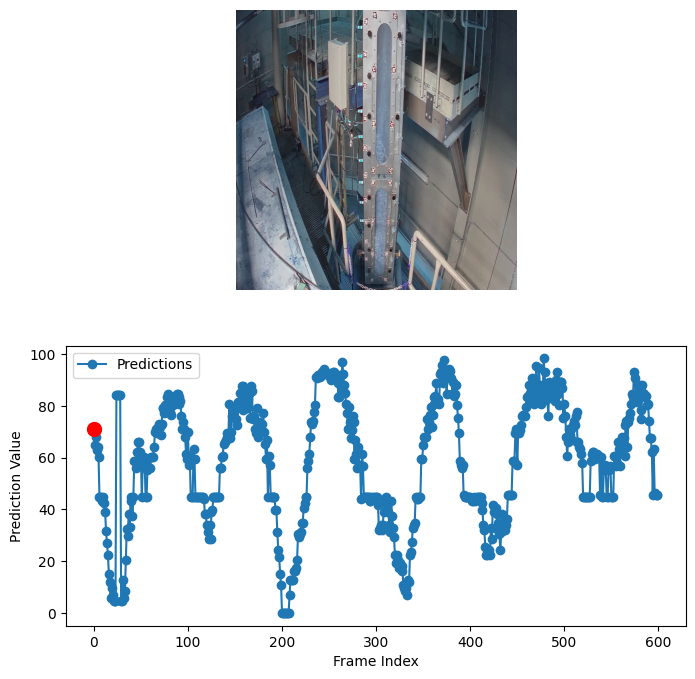

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.widgets import Cursor
from tqdm import tqdm
import cv2 
# Load data
data_path = '../../data/predictions/new_run/sensors_with_strawbbox.hdf5'
hf = h5py.File(data_path, 'r')

timestamps = list(hf.keys())
if "frame" == timestamps[0].split("_")[0]:
    timestamps = sorted(timestamps, key=lambda x: int(x.split('_')[1]))
else:
    timestamps = sorted(timestamps, key=lambda x: float(x))

# Extract values for plotting
values = [hf[t]['straw_percent_bbox']['percent'][()] for t in timestamps]

# Initialize figure and axis
fig, (ax_img, ax_plot) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the predictions
time_indices = np.arange(len(values))
ax_plot.plot(time_indices, values, marker='o', linestyle='-', label='Predictions')
current_point, = ax_plot.plot([], [], 'ro', markersize=10)  # Indicator for the current frame
ax_plot.set_xlabel("Frame Index")
ax_plot.set_ylabel("Prediction Value")
ax_plot.legend()

# Display first image
img_display = ax_img.imshow(np.zeros((100, 100)), cmap='gray')  # Placeholder image
ax_img.axis("off")

# State tracking
index = 0

def update_display():
    """ Update the image and plot marker based on the current index. """
    global index
    key = timestamps[index]
    image_data = hf[key]['image'][...]
    image_array = np.frombuffer(image_data, np.uint8)
    # Decode the image
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img_display.set_data(image)
    
    # Update plot indicator
    current_point.set_data(index, values[index])
    
    fig.canvas.draw_idle()

# Key event handler
def on_key(event):
    global index
    if event.key == "right" and index < len(timestamps) - 1:
        index += 1
    elif event.key == "left" and index > 0:
        index -= 1
    update_display()

# Connect event
global cid
cid = fig.canvas.mpl_connect("key_press_event", on_key)

# Initial display
update_display()
plt.show()

# Close file after execution
hf.close()
